# Preprocessing of data

Disclaimer: Most of the steps here are taken from the scanpy tutorial "Preprocessing and clustering 3k PBMCs" (https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

1. Read the anndata file with sc-expression information
2. Mark the two different branches with selecting cells for each branch
3. Slice the trajectories into windows
4. Infer the adjacencies for each window and create modules and regulons
5. Write the results to files

In [15]:
import numpy as np
import pandas as pd
import scanpy as sc

# sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
#results_file = 'script_trajectories.h5ad'

In [16]:
WALKER=0.01
WINDOW_SIZE=0.02

PATH_TO_LOOM_DIR='data_files/looms/'
PATH_TO_ADJ_TSV_DIR='data_files/adjacencies/'
PATH_TO_MOTIFS_DIR='data_files/motifs/'
PATH_TO_REGULONS_DIR='data_files/regulons/'
PATH_TO_DATAFRAMES_DIR='data_files/dataframes/'
PATH_TO_RESULT_DF='abs_matrix.txt'

# motif database and tf names
PATH_TO_MOTIF_DB="../../data/databases/motifs/mm9/motifs-v9-nr.mgi-m0.001-o0.0.tbl"
PATH_TO_TF_LIST="../../data/tf_lists/mm_tfs_list.txt"

# feather gene databases
DATABASE_FOLDER = "../../data/databases/genes/mm9/"
FEATHER_FILES_REGEX="mm9-*.mc9nr.feather"
# DATABASES_GLOB = os.path.join(DATABASE_FOLDER, FEATHER_FILES_REGEX)    # done below

### 1. Read the anndata file with sc-expression information

In [17]:
# get dataset
adata = sc.read_h5ad("../../data/trajectory_sets/test5.h5ad")

/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [18]:
adata

AnnData object with n_obs × n_vars = 1646 × 2000
    obs: 'paper_clust', 'true_clsts', 'controls', 'louvain', 'dpt_pseudotime'
    uns: 'controls_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'neighbors', 'paga', 'pca', 'true_clsts_colors', 'true_clsts_sizes'
    obsm: 'X_pca', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

#### Visualizing the data

In [19]:
adata

AnnData object with n_obs × n_vars = 1646 × 2000
    obs: 'paper_clust', 'true_clsts', 'controls', 'louvain', 'dpt_pseudotime'
    uns: 'controls_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'neighbors', 'paga', 'pca', 'true_clsts_colors', 'true_clsts_sizes'
    obsm: 'X_pca', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

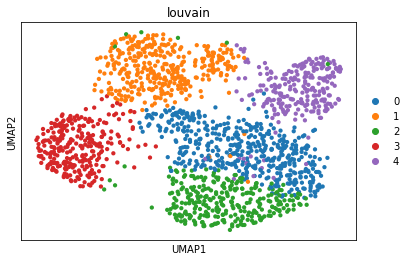

In [20]:
sc.pl.umap(adata, color='louvain')

You might want to filter cells and genes with entries to make the set smaller:

In [21]:
# sc.pp.filter_cells(adata, min_counts=1)

In [22]:
# sc.pp.filter_genes(adata, min_cells=1)

In [23]:
sc.tl.draw_graph(adata, color=['dpt_pseudotime'])

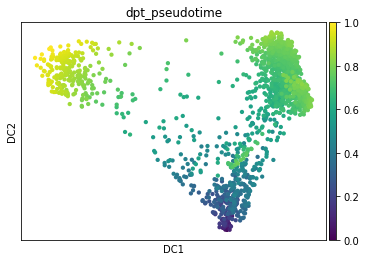

In [24]:
sc.pl.diffmap(adata, color=['dpt_pseudotime'])

Remove the cluster '0' (s. [20]) because these are not wanted for analysis.

In [25]:
adata = adata[adata.obs['louvain'].isin(['1', '2', '3', '4']),:]

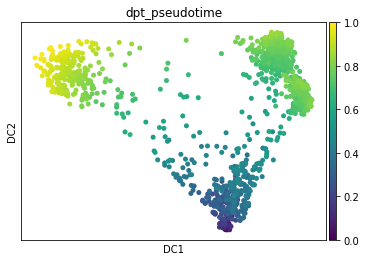

In [26]:
sc.pl.diffmap(adata, color=['dpt_pseudotime'])

Plot the trajectories.

In [27]:
a=adata.obsm['X_diffmap'][:, 1]
b=adata.obsm['X_diffmap'][:, 2]

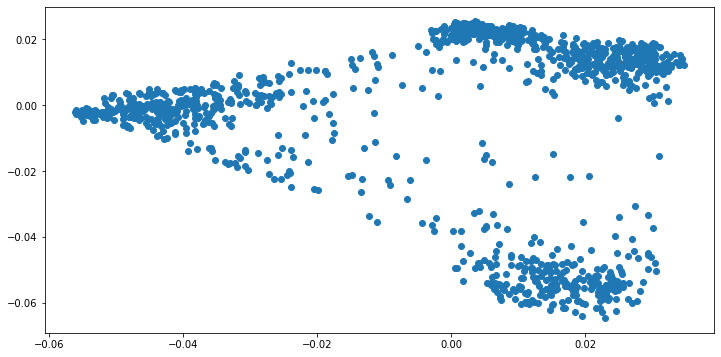

In [28]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 6]
c=matplotlib.pyplot.scatter(b, a)

### 2. Mark the two different branches with selecting cells for each branch

In [33]:
import plotly.graph_objs as go
import numpy as np

f = go.FigureWidget([go.Scatter(x=b, y=a, mode='markers')])

scatter = f.data[0]
colors = ['#000000'] * len(a)
scatter.marker.color = colors
scatter.marker.size = [10] * len(a)
f.layout.hovermode = 'closest'

global selection
selection=[]
# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#cc0000'
        s[i] = 10
        scatter.marker.color = c
        scatter.marker.size = s
        selection.append(i)



scatter.on_click(update_point)
f



FigureWidget({
    'data': [{'marker': {'color': [#000000, #000000, #000000, ..., #000000,
                   …

In [34]:
# select some cells in branch A
print(len(selection))
walker=WALKER

for x in selection:
    for i in range(len(data)):
        if data[x][0]-walker<=data[i][0]<=data[x][0]+walker and data[x][1]-walker<=data[i][1]<=data[x][1]+walker:
            data[i][2]='red'

19


In [35]:
import plotly.graph_objs as go
import numpy as np

f = go.FigureWidget([go.Scatter(x=b, y=a, mode='markers')])

scatter = f.data[0]
colors = ['#000000'] * len(a)
scatter.marker.color = colors
scatter.marker.size = [10] * len(a)
f.layout.hovermode = 'closest'

global selection
selection=[]
# create our callback function
def update_point(trace, points, selector):
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    for i in points.point_inds:
        c[i] = '#cc0000'
        s[i] = 10
        scatter.marker.color = c
        scatter.marker.size = s
        selection.append(i)



scatter.on_click(update_point)
f


FigureWidget({
    'data': [{'marker': {'color': [#000000, #000000, #000000, ..., #000000,
                   …

In [36]:
# select some cells in branch B
walker=WALKER


for x in selection:
    for i in range(len(data)):
        if data[x][0]-walker<=data[i][0]<=data[x][0]+walker and data[x][1]-walker<=data[i][1]<=data[x][1]+walker:
            if data[i][2]=='black':
                data[i][2]='blue'
            if data[i][2]=='red':
                data[i][2]='purple'
            

In [37]:
a=[]
b=[]
c=[]
for x in data:
    a.append(x[0])
    b.append(x[1])
    c.append(x[2])

Visualize the branches. If the result is not satisfactory try adjusting WALKER. The larger the WALKER the more cells will be chosen around a selected cell.

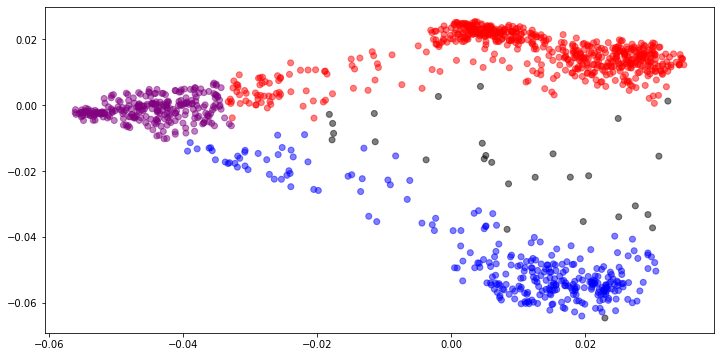

In [38]:
import numpy as np
import matplotlib.pyplot as plt


x = np.asanyarray(b)
y = np.asanyarray(a)
colors = np.asanyarray(c)

plt.scatter(x, y, c=colors, alpha=0.5)
plt.show()

In [42]:
ba=[]
bb=[]
for i in range(len(data)):
    if data[i][2]=='red':    # if cell is in branch A
        ba.append(i)
    elif data[i][2]=='blue': # if cell is in branch B
        bb.append(i)
    elif data[i][2]=='purple':  # if cell is in both branches (spot where the branches divide)
        ba.append(i)
        bb.append(i)

In [44]:
branchA=adata[ba]
branchB=adata[bb]

In [45]:
branchA,branchB

(View of AnnData object with n_obs × n_vars = 860 × 2000
     obs: 'paper_clust', 'true_clsts', 'controls', 'louvain', 'dpt_pseudotime'
     uns: 'controls_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'neighbors', 'paga', 'pca', 'true_clsts_colors', 'true_clsts_sizes', 'louvain_colors'
     obsm: 'X_pca', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
     varm: 'PCs'
     obsp: 'distances', 'connectivities',
 View of AnnData object with n_obs × n_vars = 565 × 2000
     obs: 'paper_clust', 'true_clsts', 'controls', 'louvain', 'dpt_pseudotime'
     uns: 'controls_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'neighbors', 'paga', 'pca', 'true_clsts_colors', 'true_clsts_sizes', 'louvain_colors'
     obsm: 'X_pca', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
     varm: 'PCs'
     obsp: 'distances', 'connectivities')

In [46]:
# changed a and b in the first two lines, so main axis in on the x axis

def plott(adata,color):
    b=adata.obsm['X_diffmap'][:, 1]
    a=adata.obsm['X_diffmap'][:, 2]
    data=[]
    for i in range(len(a)):
        data.append([a[i],b[i],color])
    a=[]
    b=[]
    c=[]
    for x in data:
        a.append(x[0])
        b.append(x[1])
        c.append(x[2])

    import numpy as np
    import matplotlib.pyplot as plt


    x = np.asanyarray(a)
    y = np.asanyarray(b)
    colors = np.asanyarray(c)

    plt.scatter(x, y, c=colors, alpha=0.5)
    return plt.show()

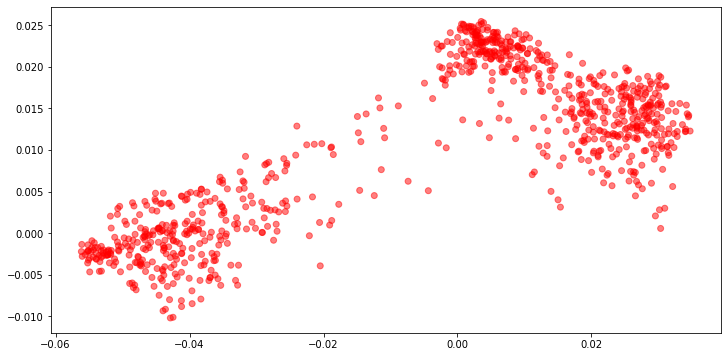

In [47]:
# plt.rcParams["figure.figsize"] = [12, 3]
plott(branchA,'red')

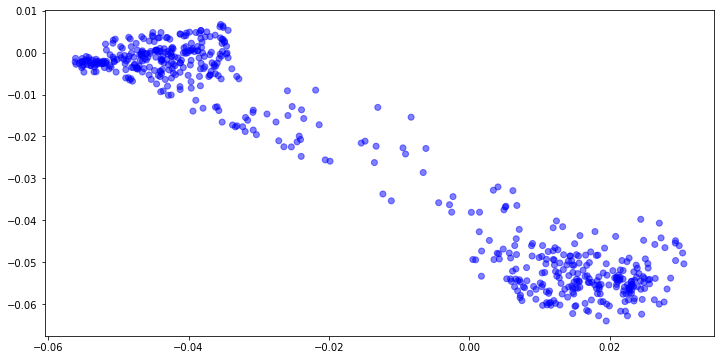

In [48]:
plott(branchB,'blue')

### 3. Slice the trajectories into windows

In [52]:
window=WINDOW_SIZE    # window size need to be selected by looking at the plots above

In [56]:
branchAwindows=[]
branchBwindows=[]

# x and y coordinates for cells in branchA and branchB
# main axis is y!!!
xa = branchA.obsm['X_diffmap'][:,1]
ya = branchA.obsm['X_diffmap'][:,2]
xb = branchB.obsm['X_diffmap'][:,1]
yb = branchB.obsm['X_diffmap'][:,2]

# get min and max y for a and b
min_ya = min(ya)
max_ya = max(ya)
min_yb = min(yb)
max_yb = max(yb)

# determine first window start
if(min_ya<min_yb): 
    start = round(min_ya, 2)
else:
    start = round(min_yb, 2)

# determine last window end
if(max_ya>max_yb):
    end = round(round(max_ya/2, 2)*2, 2)
else:
    end = round(round(max_yb/2, 2)*2, 2)
    
num_windows = round((end-start)/window)
num_windows

5

In [58]:
# reset
# branchAwindows=[]
# branchBwindows=[]

In [59]:
# create an empty anndata to add as null value
import anndata
empty_anndata = anndata.AnnData(np.empty((0, 0)))

In [60]:
# add list of cells of branchA in each window to branchAwindows
i = start

while i<end:
    current_window=[]
    for c in range(len(branchA)):
        x = branchA[c].obsm['X_diffmap'][0][2]  #[0][2] because y is main axis
        if(i<x and x<i+window):
            current_window.append(c)
            
    if current_window!=[]:
        branchAwindows.append(branchA[current_window])
    else:
        branchAwindows.append(empty_anndata)
    i+=window

    

In [61]:
# same for branchB
i = start

while i<end:
    current_window=[]
    for c in range(len(branchB)):
        x = branchB[c].obsm['X_diffmap'][0][2]  #[0][2] because y is main axis
        if(i<x and x<i+window):
            current_window.append(c)
        
    if current_window!=[]:
        branchBwindows.append(branchB[current_window])
    else:
        branchBwindows.append(empty_anndata)
    i+=window

In [62]:
# branchBwindows

In [63]:
# plott(branchAwindows[3], 'red')

In [64]:
# plott(branchBwindows[1], 'blue')


In [65]:
branchAwindows[1]

View of AnnData object with n_obs × n_vars = 126 × 2000
    obs: 'paper_clust', 'true_clsts', 'controls', 'louvain', 'dpt_pseudotime'
    uns: 'controls_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'louvain', 'neighbors', 'paga', 'pca', 'true_clsts_colors', 'true_clsts_sizes', 'louvain_colors'
    obsm: 'X_pca', 'X_umap', 'X_diffmap', 'X_draw_graph_fa'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Save the data for each window and each branch in different h5ad files.

In [67]:
WINDOW_ANNDATA = 'data_files/windows_anndata'
for i in range(num_windows):
    branchAwindows[i].write(f'{WINDOW_ANNDATA}/window_{i}A.h5ad')
    branchBwindows[i].write(f'{WINDOW_ANNDATA}/window_{i}B.h5ad')

### 4. Infer the adjacencies for each window and create modules and regulons

Create loom files as input for grnboost later.

In [49]:
def create_file(adata, filename):
    # create basic row and column attributes for the loom file:
    row_attrs = {
        "Gene": np.array(adata.var_names) ,
    }
    col_attrs = {
        "CellID": np.array(adata.obs_names) ,
        "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
        "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
    }
    lp.create(filename, adata.X.transpose(), row_attrs, col_attrs)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
from dask.diagnostics import ProgressBar
from pyscenic.prune import prune2df, df2regulons
from pyscenic.utils import modules_from_adjacencies, load_motifs
from arboreto.utils import load_tf_names
from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
import os
import pickle
import glob
import loompy as lp
from pyscenic.utils import modules_from_adjacencies, load_motifs
import re

/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [51]:
# create a loom file for each window of branchA
counter=0
for group in branchAwindows:
    if(group.n_obs==0): 
        counter+=1
        continue
    create_file(group, f'{PATH_TO_LOOM_DIR}A_{counter}_exprMat.loom')
    counter+=1

In [52]:
# same for branchB
counter=0
for group in branchBwindows:
    if(group.n_obs==0): 
        counter+=1
        continue
    create_file(group, f'{PATH_TO_LOOM_DIR}B_{counter}_exprMat.loom')
    counter+=1

In [4]:
import glob
filenames=(glob.glob(f'{PATH_TO_LOOM_DIR}/*.loom')) 

Infer the adjacencies for each group, this might take a while.


In [54]:
for filename in filenames:
    !arboreto_with_multiprocessing.py \
    {filename} \
    {PATH_TO_TF_LIST} \
    --method grnboost2 \
    --output {PATH_TO_ADJ_TSV_DIR}{os.path.basename(filename)}_adj.tsv \
    --num_workers 10 \
    --seed 777


/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Loaded expression matrix of 126 cells and 2000 genes in 0.01888275146484375 seconds...
Loaded 1721 TFs...
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()
starting grnboost2 using 10 processes...
10

Loaded expression matrix of 227 cells and 2000 genes in 0.015222787857055664 seconds...
Loaded 1721 TFs...
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()
starting grnboost2 using 10 processes...
100%|██████████████████████████████████████| 2000/2000 [00:03<00:00, 553.37it/s]
Done in 4.135217189788818 seconds.
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the defa

Create the modules for each group, this might take a while.

In [6]:
basenames=[os.path.basename(filename) for filename in filenames]

In [7]:
modules_dict={}    # a dictionary for the modules, key = basename (e.g. 'A_1_exprMat.loom')
for basename in basenames:
    print(basename)
    if not os.path.exists(f"{PATH_TO_ADJ_TSV_DIR}/{basename}_adj.tsv"):
        continue;
    adjacencies = pd.read_csv(f"{PATH_TO_ADJ_TSV_DIR}/{basename}_adj.tsv", index_col=False, sep='\t')
    lf = lp.connect(f"{PATH_TO_LOOM_DIR}/{basename}", mode='r', validate=False)
    expr_mat_df = pd.DataFrame(lf[:, :], index=lf.ra.Gene, columns=lf.ca.CellID).T
    modules_dict[basename] = list(modules_from_adjacencies(adjacencies, expr_mat_df))

A_1_exprMat.loom



2021-04-16 10:34:42,091 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-04-16 10:34:42,109 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/nfs/home/students/l.willruth/.conda/envs/myenv/lib/python3.6/site-packages/numpy/lib/functio

A_2_exprMat.loom



2021-04-16 10:34:55,292 - pyscenic.utils - INFO - Creating modules.


A_0_exprMat.loom



2021-04-16 10:35:05,384 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-04-16 10:35:05,404 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2021-04-16 10:35:06,876 - pyscenic.utils - INFO - Creating modules.

2021-04-16 10:35:16,981 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-04-16 10:35:16,997 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the

B_4_exprMat.loom



2021-04-16 10:35:18,286 - pyscenic.utils - INFO - Creating modules.

2021-04-16 10:35:28,221 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-04-16 10:35:28,239 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].


B_3_exprMat.loom



2021-04-16 10:35:29,614 - pyscenic.utils - INFO - Creating modules.


A_3_exprMat.loom



2021-04-16 10:35:39,763 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-04-16 10:35:39,782 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2021-04-16 10:35:41,195 - pyscenic.utils - INFO - Creating modules.

2021-04-16 10:35:51,309 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-04-16 10:35:51,327 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the

B_1_exprMat.loom



2021-04-16 10:35:52,736 - pyscenic.utils - INFO - Creating modules.


A_4_exprMat.loom



2021-04-16 10:36:03,143 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-04-16 10:36:03,160 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2021-04-16 10:36:04,479 - pyscenic.utils - INFO - Creating modules.


B_2_exprMat.loom



2021-04-16 10:36:14,571 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-04-16 10:36:14,587 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2021-04-16 10:36:15,802 - pyscenic.utils - INFO - Creating modules.

2021-04-16 10:36:24,935 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-04-16 10:36:24,955 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the

B_0_exprMat.loom



2021-04-16 10:36:26,339 - pyscenic.utils - INFO - Creating modules.


In [5]:
# motif database and tf names
motif_db = PATH_TO_MOTIF_DB
tf_names = load_tf_names(PATH_TO_TF_LIST)

# feather gene databases
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, FEATHER_FILES_REGEX)

In [59]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="mm9-tss-centered-5kb-7species.mc9nr"),
 FeatherRankingDatabase(name="mm9-500bp-upstream-7species.mc9nr"),
 FeatherRankingDatabase(name="mm9-500bp-upstream-10species.mc9nr"),
 FeatherRankingDatabase(name="mm9-tss-centered-10kb-7species.mc9nr"),
 FeatherRankingDatabase(name="mm9-tss-centered-10kb-10species.mc9nr"),
 FeatherRankingDatabase(name="mm9-tss-centered-5kb-10species.mc9nr")]

Creating the regulons, this might take a while.

In [60]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
for key, modules in modules_dict.items():
    with ProgressBar():
        df = prune2df(dbs, modules, motif_db, num_workers=10) # increase to 15 or 20

    # Create regulons from this table of enriched motifs.
    regulons = df2regulons(df)

    # Save the enriched motifs and the discovered regulons to disk.
    df.to_csv(f"{PATH_TO_MOTIFS_DIR}{key}_motif.csv")
    with open(f"{PATH_TO_REGULONS_DIR}{key}_regulons.p", "wb") as f:
        pickle.dump(regulons, f)

[########################################] | 100% Completed |  5min 13.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[                                        ] | 0% Completed | 10.8s


2021-04-14 13:59:36,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Psmd12 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 15.8s


2021-04-14 13:59:41,957 - pyscenic.transform - WARNING - Less than 80% of the genes in D130040H23Rik could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 27.7s


2021-04-14 13:59:53,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Timm44 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 34.4s


2021-04-14 14:00:00,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for D130040H23Rik could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 58.1s


2021-04-14 14:00:24,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Psmd12 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min  5.2s


2021-04-14 14:00:31,332 - pyscenic.transform - WARNING - Less than 80% of the genes in D130040H23Rik could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min 12.4s


2021-04-14 14:00:38,537 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Timm44 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min 16.7s


2021-04-14 14:00:42,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for D130040H23Rik could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  1min 34.2s


2021-04-14 14:01:00,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Psmd12 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  1min 43.8s


2021-04-14 14:01:10,005 - pyscenic.transform - WARNING - Less than 80% of the genes in D130040H23Rik could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  1min 49.8s


2021-04-14 14:01:15,908 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Timm44 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  2min  1.7s


2021-04-14 14:01:27,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for D130040H23Rik could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  2min 19.9s


2021-04-14 14:01:46,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Psmd12 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  2min 31.2s


2021-04-14 14:01:57,340 - pyscenic.transform - WARNING - Less than 80% of the genes in D130040H23Rik could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  2min 36.7s


2021-04-14 14:02:02,889 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Timm44 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  2min 42.0s


2021-04-14 14:02:08,138 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for D130040H23Rik could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  3min 11.0s


2021-04-14 14:02:37,169 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Psmd12 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  3min 15.9s


2021-04-14 14:02:42,065 - pyscenic.transform - WARNING - Less than 80% of the genes in D130040H23Rik could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  3min 31.3s


2021-04-14 14:02:57,461 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Timm44 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  3min 36.7s


2021-04-14 14:03:02,936 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for D130040H23Rik could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  3min 53.8s


2021-04-14 14:03:19,932 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Psmd12 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  3min 59.5s


2021-04-14 14:03:25,709 - pyscenic.transform - WARNING - Less than 80% of the genes in D130040H23Rik could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  4min 10.8s


2021-04-14 14:03:37,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Timm44 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  4min 18.3s


2021-04-14 14:03:44,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for D130040H23Rik could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[########################################] | 100% Completed |  5min 23.5s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[                                        ] | 0% Completed |  7.0s


2021-04-14 14:05:16,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 15.2s


2021-04-14 14:05:24,809 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 21.2s


2021-04-14 14:05:30,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 22.4s


2021-04-14 14:05:32,053 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 25.6s


2021-04-14 14:05:35,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 27.7s


2021-04-14 14:05:37,346 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Rbm22 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed | 43.7s


2021-04-14 14:05:53,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed | 47.8s


2021-04-14 14:05:57,495 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 54.4s


2021-04-14 14:06:04,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed | 59.4s


2021-04-14 14:06:09,095 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min  2.9s


2021-04-14 14:06:12,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min  4.4s


2021-04-14 14:06:14,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Rbm22 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min  5.9s


2021-04-14 14:06:15,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.

[######                                  ] | 15% Completed |  1min  6.0s

[#########                               ] | 23% Completed |  1min 28.6s


2021-04-14 14:06:38,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  1min 30.5s


2021-04-14 14:06:40,205 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.

[#########                               ] | 23% Completed |  1min 30.6s

[##########                              ] | 25% Completed |  1min 33.9s


2021-04-14 14:06:43,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  1min 34.1s


2021-04-14 14:06:43,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  1min 39.2s


2021-04-14 14:06:48,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  1min 40.4s


2021-04-14 14:06:49,991 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Rbm22 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  1min 49.5s


2021-04-14 14:06:59,126 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  2min 15.8s


2021-04-14 14:07:25,498 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.

[################                        ] | 41% Completed |  2min 15.9s

[################                        ] | 41% Completed |  2min 16.0s


2021-04-14 14:07:25,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  2min 16.7s


2021-04-14 14:07:26,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  2min 22.4s


2021-04-14 14:07:32,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  2min 24.2s


2021-04-14 14:07:33,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  2min 29.5s


2021-04-14 14:07:39,220 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Rbm22 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  2min 43.9s


2021-04-14 14:07:53,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  2min 57.1s


2021-04-14 14:08:06,799 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  2min 59.7s


2021-04-14 14:08:09,287 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  3min  4.3s


2021-04-14 14:08:14,051 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.

[#######################                 ] | 58% Completed |  3min  4.5s

[########################                ] | 60% Completed |  3min  5.8s


2021-04-14 14:08:15,456 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  3min  9.8s


2021-04-14 14:08:19,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Rbm22 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  3min 13.2s


2021-04-14 14:08:23,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  3min 25.3s


2021-04-14 14:08:34,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[#############################           ] | 74% Completed |  3min 45.8s


2021-04-14 14:08:55,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  3min 48.1s


2021-04-14 14:08:57,775 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  3min 53.2s


2021-04-14 14:09:02,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  3min 53.5s


2021-04-14 14:09:03,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  3min 54.7s


2021-04-14 14:09:04,293 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Bclaf1 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  3min 58.2s


2021-04-14 14:09:07,880 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Rbm22 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  4min  8.4s


2021-04-14 14:09:18,099 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  4min 29.5s


2021-04-14 14:09:39,085 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[########################################] | 100% Completed |  5min 14.4s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[                                        ] | 0% Completed | 16.5s


2021-04-14 14:10:59,306 - pyscenic.transform - WARNING - Less than 80% of the genes in Nr4a2 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[###                                     ] | 7% Completed | 47.2s


2021-04-14 14:11:29,765 - pyscenic.transform - WARNING - Less than 80% of the genes in Ncald could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  1min 10.0s


2021-04-14 14:11:52,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Nr4a2 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 24.4s


2021-04-14 14:12:07,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Ncald could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  1min 51.4s


2021-04-14 14:12:34,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Nr4a2 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  2min 12.7s


2021-04-14 14:12:55,544 - pyscenic.transform - WARNING - Less than 80% of the genes in Ncald could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  2min 45.5s


2021-04-14 14:13:28,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Nr4a2 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 56% Completed |  2min 58.9s


2021-04-14 14:13:41,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Ncald could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  3min 26.6s


2021-04-14 14:14:09,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Nr4a2 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  3min 49.7s


2021-04-14 14:14:32,534 - pyscenic.transform - WARNING - Less than 80% of the genes in Ncald could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  4min 16.6s


2021-04-14 14:14:59,369 - pyscenic.transform - WARNING - Less than 80% of the genes in Nr4a2 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  4min 32.0s


2021-04-14 14:15:14,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Ncald could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[########################################] | 100% Completed |  5min 13.7s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[                                        ] | 0% Completed |  7.7s


2021-04-14 14:16:22,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Ash2l could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed | 51.4s


2021-04-14 14:17:05,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Ash2l could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[###########                             ] | 27% Completed |  1min 31.4s


2021-04-14 14:17:45,932 - pyscenic.transform - WARNING - Less than 80% of the genes in Ash2l could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  2min 12.4s


2021-04-14 14:18:26,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Ash2l could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  3min  0.2s


2021-04-14 14:19:14,734 - pyscenic.transform - WARNING - Less than 80% of the genes in Ash2l could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  3min 43.5s


2021-04-14 14:19:57,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Ash2l could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[########################################] | 100% Completed |  5min  2.6s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[###                                     ] | 8% Completed | 50.0s


2021-04-14 14:22:30,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Trim21 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  1min 33.0s


2021-04-14 14:23:12,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Trim21 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  2min 13.6s


2021-04-14 14:23:53,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Trim21 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  3min  0.3s


2021-04-14 14:24:40,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Trim21 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  3min 52.2s


2021-04-14 14:25:32,113 - pyscenic.transform - WARNING - Less than 80% of the genes in Trim21 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  4min 33.8s


2021-04-14 14:26:13,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Trim21 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[########################################] | 100% Completed |  5min  6.5s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[#                                       ] | 3% Completed | 41.2s


2021-04-14 14:27:45,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Nelfb could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 52.3s


2021-04-14 14:27:56,217 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nelfb could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  1min 21.4s


2021-04-14 14:28:25,287 - pyscenic.transform - WARNING - Less than 80% of the genes in Nelfb could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  1min 27.5s


2021-04-14 14:28:31,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nelfb could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  1min 58.6s


2021-04-14 14:29:02,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Nelfb could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  2min 11.0s


2021-04-14 14:29:15,112 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nelfb could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  2min 51.5s


2021-04-14 14:29:55,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nelfb could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed |  2min 52.0s


2021-04-14 14:29:56,025 - pyscenic.transform - WARNING - Less than 80% of the genes in Nelfb could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  3min 37.7s


2021-04-14 14:30:41,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nelfb could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  3min 45.8s


2021-04-14 14:30:49,702 - pyscenic.transform - WARNING - Less than 80% of the genes in Nelfb could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  4min 19.7s


2021-04-14 14:31:23,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Nelfb could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  4min 22.4s


2021-04-14 14:31:26,324 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nelfb could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[########################################] | 100% Completed |  5min 20.5s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[                                        ] | 0% Completed |  6.8s


2021-04-14 14:32:54,736 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.2s


2021-04-14 14:33:06,126 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 30.8s


2021-04-14 14:33:18,821 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Sp100 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed | 41.0s


2021-04-14 14:33:28,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Rbm17 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed | 45.1s


2021-04-14 14:33:33,051 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed | 52.0s


2021-04-14 14:33:39,938 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min  7.6s


2021-04-14 14:33:55,537 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Sp100 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  1min 25.7s


2021-04-14 14:34:13,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  1min 29.6s


2021-04-14 14:34:17,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Rbm17 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  1min 30.2s


2021-04-14 14:34:18,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  1min 46.2s


2021-04-14 14:34:34,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Sp100 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  2min  3.0s


2021-04-14 14:34:50,876 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  2min 14.8s


2021-04-14 14:35:02,653 - pyscenic.transform - WARNING - Less than 80% of the genes in Rbm17 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  2min 15.4s


2021-04-14 14:35:03,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  2min 28.2s


2021-04-14 14:35:16,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Sp100 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  2min 51.0s


2021-04-14 14:35:39,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.

[#######################                 ] | 59% Completed |  2min 51.1s

[########################                ] | 60% Completed |  2min 52.5s


2021-04-14 14:35:40,544 - pyscenic.transform - WARNING - Less than 80% of the genes in Rbm17 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 60% Completed |  2min 53.8s


2021-04-14 14:35:41,738 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  3min  6.6s


2021-04-14 14:35:54,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Sp100 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[############################            ] | 70% Completed |  3min 25.4s


2021-04-14 14:36:13,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Rbm17 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[##############################          ] | 76% Completed |  3min 32.8s


2021-04-14 14:36:20,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  3min 39.0s


2021-04-14 14:36:26,957 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Nfyb could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  3min 52.0s


2021-04-14 14:36:39,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Sp100 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  4min  2.2s


2021-04-14 14:36:50,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Rbm17 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[########################################] | 100% Completed |  4min 55.2s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[                                        ] | 1% Completed | 23.8s


2021-04-14 14:38:25,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Git2 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed | 36.4s


2021-04-14 14:38:38,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Git2 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed | 50.8s


2021-04-14 14:38:53,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.

[####                                    ] | 11% Completed | 51.4s

[##########                              ] | 25% Completed |  1min 19.6s


2021-04-14 14:39:21,633 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[###########                             ] | 27% Completed |  1min 23.6s


2021-04-14 14:39:25,582 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Git2 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  1min 42.4s


2021-04-14 14:39:44,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  2min  0.5s


2021-04-14 14:40:02,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Git2 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  2min 30.1s


2021-04-14 14:40:32,276 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  2min 35.8s


2021-04-14 14:40:37,886 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Git2 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  3min  6.4s


2021-04-14 14:41:08,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Git2 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[##############################          ] | 75% Completed |  3min 13.0s


2021-04-14 14:41:15,071 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  3min 43.7s


2021-04-14 14:41:45,819 - pyscenic.transform - WARNING - Less than 80% of the genes in Yeats4 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[########################################] | 100% Completed |  4min 16.2s
Create regulons from a dataframe of enriched features.
Additional columns saved: []
[                                        ] | 0% Completed |  7.3s


2021-04-14 14:42:35,930 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 28.0s


2021-04-14 14:42:56,519 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Tsc22d4 could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed | 45.3s


2021-04-14 14:43:13,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-tss-centered-5kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed | 49.6s


2021-04-14 14:43:18,145 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  1min  2.7s


2021-04-14 14:43:31,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Tsc22d4 could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  1min 20.3s


2021-04-14 14:43:48,917 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-500bp-upstream-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  1min 27.9s


2021-04-14 14:43:56,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  1min 45.1s


2021-04-14 14:44:13,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Tsc22d4 could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  1min 54.5s


2021-04-14 14:44:22,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-500bp-upstream-10species.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  2min  8.5s


2021-04-14 14:44:37,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  2min 34.1s


2021-04-14 14:45:02,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Tsc22d4 could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  2min 41.1s


2021-04-14 14:45:09,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  2min 58.2s


2021-04-14 14:45:26,790 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  3min 17.0s


2021-04-14 14:45:45,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Tsc22d4 could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  3min 31.0s


2021-04-14 14:45:59,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-tss-centered-10kb-10species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  3min 42.8s


2021-04-14 14:46:11,381 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Noc2l could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  4min  3.0s


2021-04-14 14:46:31,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for Tsc22d4 could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  4min 15.5s


2021-04-14 14:46:43,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Noc2l could be mapped to mm9-tss-centered-5kb-10species.mc9nr. Skipping this module.


[########################################] | 100% Completed |  5min 11.1s
Create regulons from a dataframe of enriched features.
Additional columns saved: []


### 5. Write the results to files

In [6]:
regnames=(glob.glob(f"{PATH_TO_REGULONS_DIR}*.p"))
regnames=[os.path.basename(regname) for regname in regnames]

In [7]:
len(regnames)

10

In [8]:
regnames

['B_0_exprMat.loom_regulons.p',
 'B_4_exprMat.loom_regulons.p',
 'B_2_exprMat.loom_regulons.p',
 'A_0_exprMat.loom_regulons.p',
 'A_3_exprMat.loom_regulons.p',
 'A_1_exprMat.loom_regulons.p',
 'A_4_exprMat.loom_regulons.p',
 'A_2_exprMat.loom_regulons.p',
 'B_3_exprMat.loom_regulons.p',
 'B_1_exprMat.loom_regulons.p']

In [10]:
# rename to save the number of regulated genes for each tf
all_regulons={}
for regname in regnames:
    with open(f'{PATH_TO_REGULONS_DIR}{regname}', 'rb') as f:
        regulons = pickle.load(f)
    regulons = [r.rename(r.name.replace('(+)', ' (' + str(len(r)) + 'g)')) for r in regulons]
    all_regulons[regname]=regulons

In [11]:
namesds={}
networks={}
for key, regulons in all_regulons.items():
    print(key)
    namesd=[]
    network=[]
    for x in regulons:
        namesd.append(x.name)
        network.append(x.gene2weight)
    print('Number of regulons :'+str(len(namesd)))
    for i in range(len(namesd)):
        namesd[i]=namesd[i].split(' ')
    for i in range(len(namesd)):
        namesd[i][1] = re.findall('\d+', namesd[i][1])
    for i in range(len(namesd)):
        namesd[i][1]=int(namesd[i][1][0])
    namesds[key]=namesd
    networks[key]=network

B_0_exprMat.loom_regulons.p
Number of regulons :60
B_4_exprMat.loom_regulons.p
Number of regulons :64
B_2_exprMat.loom_regulons.p
Number of regulons :58
A_0_exprMat.loom_regulons.p
Number of regulons :61
A_3_exprMat.loom_regulons.p
Number of regulons :62
A_1_exprMat.loom_regulons.p
Number of regulons :64
A_4_exprMat.loom_regulons.p
Number of regulons :63
A_2_exprMat.loom_regulons.p
Number of regulons :63
B_3_exprMat.loom_regulons.p
Number of regulons :65
B_1_exprMat.loom_regulons.p
Number of regulons :57


In [13]:
networks

{'B_0_exprMat.loom_regulons.p': [<frozendict {'Csde1': 1.6336769026033346, 'Nipbl': 1.95762964564884, 'Stk17b': 1.95762964564884, 'Smpdl3a': 1.95762964564884, 'Cetn3': 0.6504561555952453, 'Dap': 1.95762964564884, 'Avl9': 1.95762964564884, 'Fcho2': 1.95762964564884, 'Capza2': 2.721889789058479, 'Top1': 1.0157803036639856, 'Aftph': 2.123731654147333, 'Pafah1b1': 1.2596211726871598, 'Stx17': 2.123731654147333, 'Ap4s1': 2.123731654147333, 'Ifi47': 2.123731654147333, 'Cyld': 2.123731654147333, 'Ypel5': 2.721889789058479, 'Psmc1': 2.721889789058479, 'Fryl': 1.7493410973734351, 'Peli1': 2.721889789058479, 'Hnrnpa2b1': 2.123731654147333, 'Dgka': 1.2939620387618913, 'Ipcef1': 0.8910867274487114, 'Ssb': 0.3064745362812735, 'Fundc2': 0.1713246382684209, 'Fam3c': 0.29472193298594496, 'Actl6a': 0.17353913293672632, 'Hnrnpr': 0.6410873581564924, 'Mysm1': 1.95762964564884, 'S100a10': 0.2659656563369228, 'Vps29': 0.3489283775504614, 'Aifm1': 0.6504561555952453, 'Azi2': 0.1771055020422409, 'C1d': 0.305

In [65]:
for key, network in networks.items():
    for i in range(len(network)):
        network[i]=dict(network[i])

In [66]:
dataframes={}
for network_key, network in networks.items():
    
    # save each tf with a list of regulated genes and a list of the corresponding weights as list in a list rows.
    network_num=0    # counter for the different networks to make a new figure for each graph
    rows=[]
    namesd=namesds[network_key]
    for tf in namesd: 
        
        genes=[]
        weights=[]
        
        for key, value in network[network_num].items():       
            genes.append(key)
            weights.append(value)
        network_num+=1
        rows.append([tf[0], genes, weights])
    dataframes[network_key]=pd.DataFrame(rows)
    dataframes[network_key].to_csv(f'{PATH_TO_DATAFRAMES_DIR}{network_key}_df_tf_genes_weights.csv', header=["TF","Genes","Weights"], index=False)

#### done: 
Dataframes as csv for all windows of the two branches with each entry being a transcription factor, a list of genes and the corresponding list of weights representing the interaction between the tf and the genes. This gives a network of tfs, genes and connections for each branch in each window. Next we will look for interactions that strongly vary in branch A and branch B by taking the absolute values between the weights. (s. 02_abs_matrix notebook)